In [0]:


import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

In [0]:
from google.colab import files
uploaded = files.upload()

Saving bbc-text.csv to bbc-text.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['bbc-text.csv']))


In [0]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

933960

In [0]:
#df = df[pd.notnull(df['category'])]
#df.head(10)

# Checking if the data is balanced

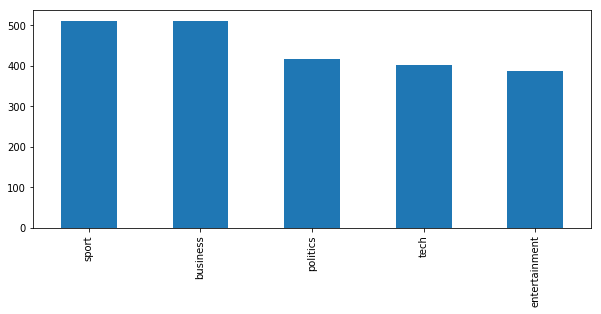

In [0]:
my_tags = ['Sports','Business','Politics','Tech','Entertainment']
plt.figure(figsize=(10,4))
df.category.value_counts().plot(kind='bar');

#Hence we can see the data is well balanced.

# Cleaning the text

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;:.""'']')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+%$!&*=_<>?]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(words):
    """
        words: a string
        
        return: modified initial string
    """
    
    words = REPLACE_BY_SPACE_RE.sub(' ', words) # replace REPLACE_BY_SPACE_RE symbols by space in text
    words = BAD_SYMBOLS_RE.sub('', words) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = ' '.join(word for word in words.split() if word not in STOPWORDS) # delete stopwors from text
    return words

In [0]:
df['text'] = df['text'].apply(clean_text)

In [0]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

496871

In [0]:
#SPLITTING THE DATA 70% TRAIN AND 30% TEST

X = df.text
y = df.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


# Naive Bayes classifier for multinomial models

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [0]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.968562874251497
               precision    recall  f1-score   support

       Sports       0.96      0.96      0.96       164
     Business       1.00      0.92      0.96       113
     Politics       0.93      0.99      0.96       113
         Tech       0.97      1.00      0.99       146
Entertainment       0.98      0.97      0.97       132

     accuracy                           0.97       668
    macro avg       0.97      0.97      0.97       668
 weighted avg       0.97      0.97      0.97       668

CPU times: user 154 ms, sys: 2.93 ms, total: 156 ms
Wall time: 159 ms


# Linear support vector machine

In [0]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [0]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9790419161676647
               precision    recall  f1-score   support

       Sports       0.97      0.95      0.96       164
     Business       1.00      0.96      0.98       113
     Politics       0.96      0.99      0.97       113
         Tech       0.98      1.00      0.99       146
Entertainment       0.98      0.99      0.99       132

     accuracy                           0.98       668
    macro avg       0.98      0.98      0.98       668
 weighted avg       0.98      0.98      0.98       668

CPU times: user 153 ms, sys: 1.15 ms, total: 154 ms
Wall time: 158 ms


# Logistic regression

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [0]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9820359281437125
               precision    recall  f1-score   support

       Sports       0.99      0.95      0.97       164
     Business       0.99      0.99      0.99       113
     Politics       0.96      0.99      0.97       113
         Tech       0.99      1.00      0.99       146
Entertainment       0.98      0.98      0.98       132

     accuracy                           0.98       668
    macro avg       0.98      0.98      0.98       668
 weighted avg       0.98      0.98      0.98       668

CPU times: user 154 ms, sys: 1.74 ms, total: 156 ms
Wall time: 157 ms
